In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Introduction

We start by opening the data and creating a pandas dataframe with all the information form the dataset. We set the "Start Date" field as the index to make data manipulation easier.

In [ ]:
df = pd.read_csv("../data/EVChargingStationUsage.csv")
df["Start Date"] = pd.to_datetime(df["Start Date"])
df["End Date"] = pd.to_datetime(df["End Date"], errors="coerce")
df["Charging Time (hh:mm:ss)"] = pd.to_timedelta(df["Charging Time (hh:mm:ss)"])
df = df.set_index(df["Start Date"])

FileNotFoundError: [Errno 2] No such file or directory: 'data/EVChargingStationUsage.csv'

We will only use fields described below for the task of predicting consumption. 

In [ ]:
df = df[["Station Name", "Energy (kWh)", "Charging Time (hh:mm:ss)"]]
df

,Station Name,Energy (kWh),Charging Time (hh:mm:ss)
Start Date,,,
2011-07-29 20:17:00,PALO ALTO CA / HAMILTON #1,6.249457,0 days 01:54:03
2011-07-30 00:00:00,PALO ALTO CA / HAMILTON #1,0.106588,0 days 00:01:54
2011-07-30 08:16:00,PALO ALTO CA / HAMILTON #1,14.951777,0 days 04:17:28
2011-07-30 14:51:00,PALO ALTO CA / HAMILTON #1,7.159643,0 days 02:02:58
2011-07-30 18:51:00,PALO ALTO CA / HAMILTON #1,1.957765,0 days 00:43:54
...,...,...,...
2020-12-31 16:39:00,PALO ALTO CA / TED THOMPSON #3,1.841000,0 days 00:35:18
2020-12-31 16:48:00,PALO ALTO CA / WEBSTER #1,12.744000,0 days 02:14:04
2020-12-31 17:28:00,PALO ALTO CA / MPL #4,29.665000,0 days 05:08:12


## Data cleaning and reformating

Now we have to reformat the data so that instead of displaying consumption for each time a car was charged on a station, we want have aggrigated data with total consumption for the whole hour for each of the stations. We will use 2 assumptions to get this: The first is a constant consumption throughout the whole charging period and the second one is that every car starts charging immediately after arriving at the charging station. The second assumption is needed since we do not know the exact time of charging start and finish, but it seems reasonable to assume that people start charging their cars right after arriving at the charging station, but they might stay at the station longer than is needed for the car to charge completely for reasons. For example, if the start date is 00:00, end date 03:00 and charging duration is 2 hours, and charging consumed 10kWh of energy, we will assume the consumption between both 00:00 to 01:00 and 01:00 to 02:00 is 5kWh, and 0kWh between 02:00 and 03:00. In other words, we ignore the end data for this prediction.

To do this, we will create a function which takes in a dataframe for one station and creates another dataframe with hourly consumption data.

In [ ]:
def get_hourly_consumption(df: pd.DataFrame) -> pd.Series:
    first_datetime = df.index.min().replace(minute=0, second=0)
    last_datetime = (df.index.max() + df.iloc[-1]["Charging Time (hh:mm:ss)"]).replace(minute=0, second=0)
    hourly_index = pd.date_range(first_datetime, last_datetime, freq="H")
    hourly_df = pd.Series(0.0, index=hourly_index)
    for index, row in df.iterrows():
        current_datetime = index
        total_consumption = row["Energy (kWh)"]
        total_duration = row["Charging Time (hh:mm:ss)"]
        end_datetime = index + total_duration
        # print(str(index) + " - " + str(end_datetime))
        while current_datetime < end_datetime:
            start_hour = current_datetime.replace(minute=0, second=0)
            end_hour = start_hour + pd.Timedelta(hours=1)
            sub_duration = min(end_hour, end_datetime) - current_datetime
            sub_consumption = total_consumption * sub_duration / total_duration
            hourly_df[start_hour] += sub_consumption
            current_datetime = end_hour
    return hourly_df

In [ ]:
station_names = df['Station Name'].unique()
len(station_names)

47

There are a total of 47 stations in the dataset. Lets create a dictionary with station names as keys and hourly energy consumption dataframe as values.

In [ ]:
hourly_consumption_by_station = dict()
for i, station_name in enumerate(station_names):
    station_df = df[df["Station Name"] == station_name]
    consumption = get_hourly_consumption(station_df)
    hourly_consumption_by_station[station_name] = consumption


## Seasonality and trend visualisation

Now we plot 3 graphs for 2 arbitrarily chosen stations to observe seasonality and trends in our data.

In [ ]:
def plot_consumption(hourly_consumption: pd.Series):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plot_day_consumption(hourly_consumption, axes[0])
    plot_week_consumption(hourly_consumption, axes[1])
    plot_month_consumption(hourly_consumption, axes[2])
    plt.show()

def plot_day_consumption(hourly_consumption: pd.Series, ax: plt.Axes):
    hourly_grouped = hourly_consumption.groupby(hourly_consumption.index.hour)
    data = [hourly_grouped.get_group(hour).values for hour in range(24) if hour in hourly_grouped.groups]
    ax.boxplot(data, positions=range(len(data)), widths=0.6, patch_artist=True, showmeans=True, showfliers=False)
    ax.set_xlabel("Hour of the day")
    ax.set_ylabel("Average consumption (kWh)")
    ax.set_title("Average consumption per hour of the day")

def plot_week_consumption(hourly_consumption: pd.Series, ax: plt.Axes):
    # Group data by day of the week
    weekly_data = [
        hourly_consumption[hourly_consumption.index.dayofweek == day].values
        for day in range(7)
    ]
    
    # Draw the boxplot
    ax.boxplot(weekly_data, positions=range(7), widths=0.6, patch_artist=True, showmeans=True, showfliers=False)
    ax.set_xlabel("Day of the week")
    ax.set_ylabel("Consumption (kWh)")
    ax.set_title("Distribution of Consumption per Day of the Week")
    ax.set_xticks(range(7))
    ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])


def plot_month_consumption(hourly_consumption: pd.Series, ax: plt.Axes):
    # Group data by month
    monthly_data = [
        hourly_consumption[hourly_consumption.index.month == month].values
        for month in range(1, 13)
    ]
    
    # Draw the boxplot
    ax.boxplot(monthly_data, positions=range(1, 13), widths=0.6, patch_artist=True, showmeans=True, showfliers=False)
    ax.set_xlabel("Month")
    ax.set_ylabel("Consumption (kWh)")
    ax.set_title("Distribution of Consumption per Month")
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    ])


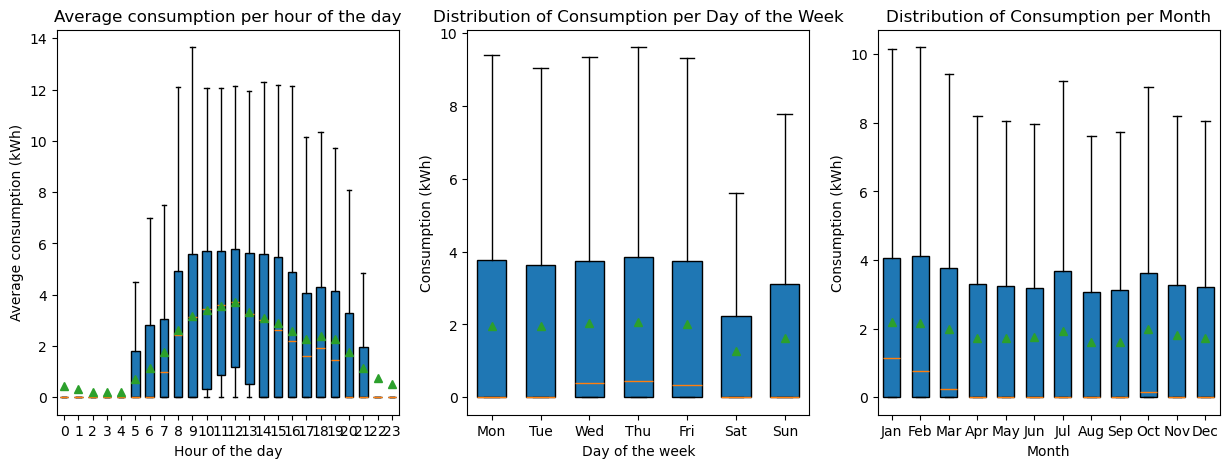

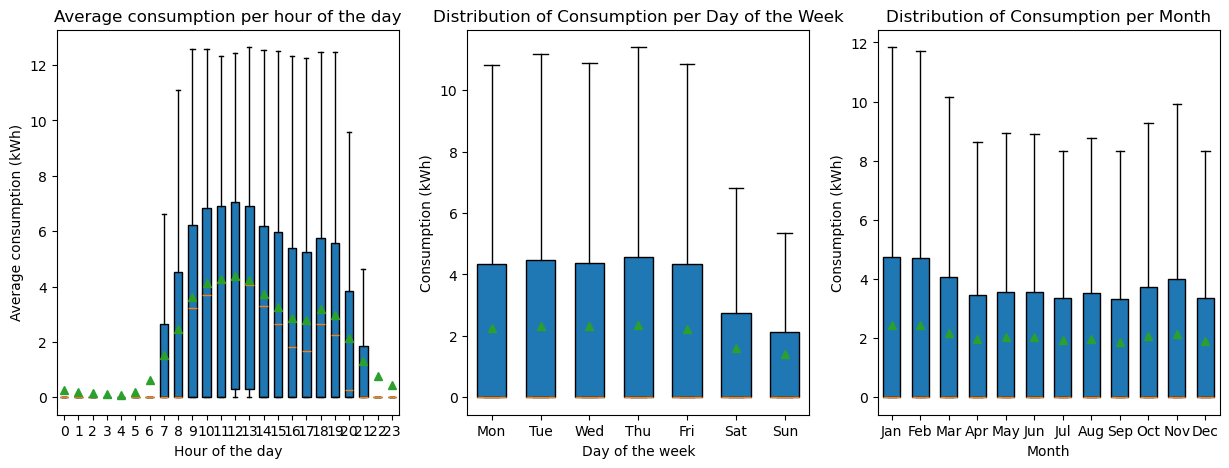

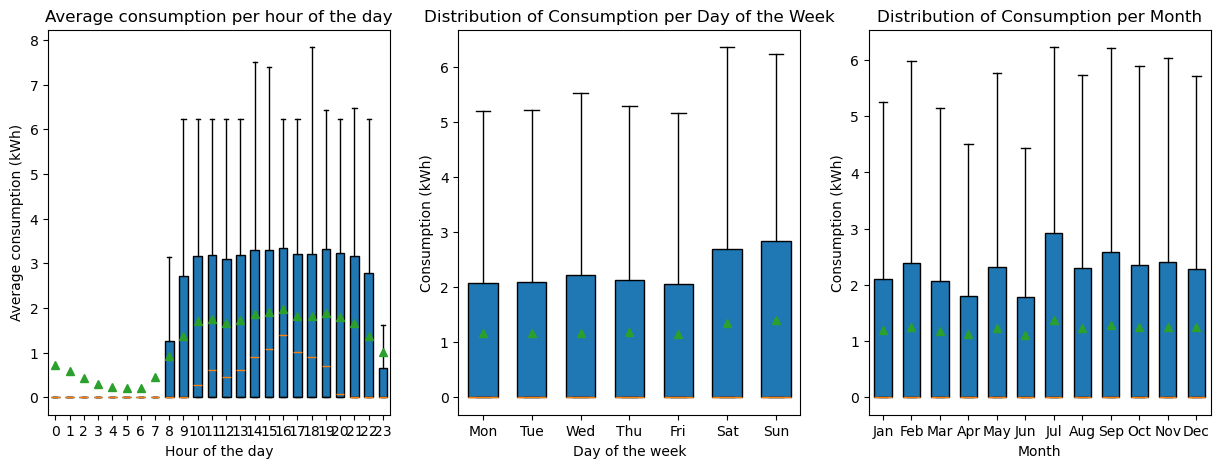

In [ ]:
plot_consumption(hourly_consumption_by_station["PALO ALTO CA / CAMBRIDGE #1"])
plot_consumption(hourly_consumption_by_station["PALO ALTO CA / HIGH #1"])
plot_consumption(hourly_consumption_by_station["PALO ALTO CA / RINCONADA LIB 1"])

The day consumption seems to be greater than the night consumption. But on the other hand, week and month patterns don't seem to match. Interestingly, the third station seems to behave differently than first 2, having more evenly distributed hourly consumption through the day, higher weekend consumption and no spikes during January and February.

Now lets visualize the trends in the data for the same 3 stations. We used daily consumption to make the graphs more readable.

In [ ]:
def plot_trends(hourly_consumption: pd.Series):
    daily_consumption = hourly_consumption.resample("D").sum()
    weekly_window = daily_consumption.rolling(window=7).mean()
    yearly_window = daily_consumption.rolling(window=365).mean()

    # Plot daily, 7-day rolling mean, and 365-day rolling mean time series
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(daily_consumption, marker='.', markersize=2, color='0.6',
    linestyle='None', label='Daily')
    ax.plot(weekly_window, linewidth=2, label='7-d Rolling Mean')
    ax.plot(yearly_window, color='0.2', linewidth=3,
    label='Trend (365-d Rolling Mean)')

    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Consumption (kWh)')
    ax.set_title('Charging Station Consumption Trend')

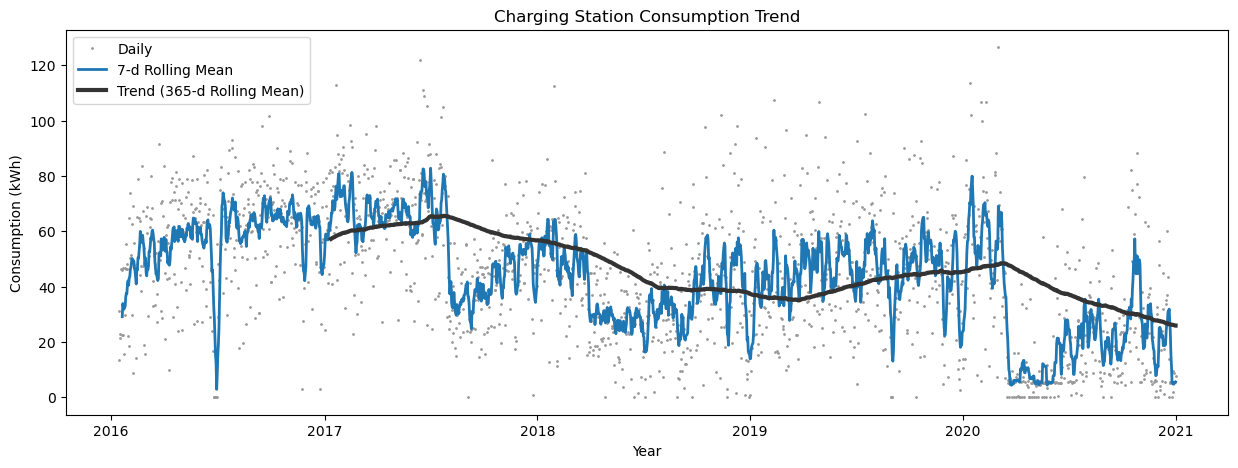

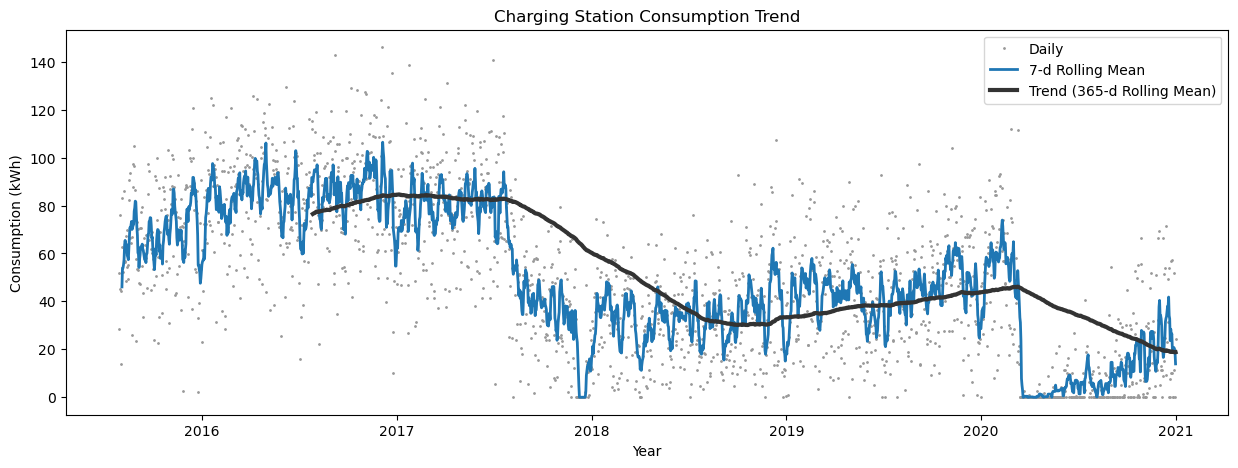

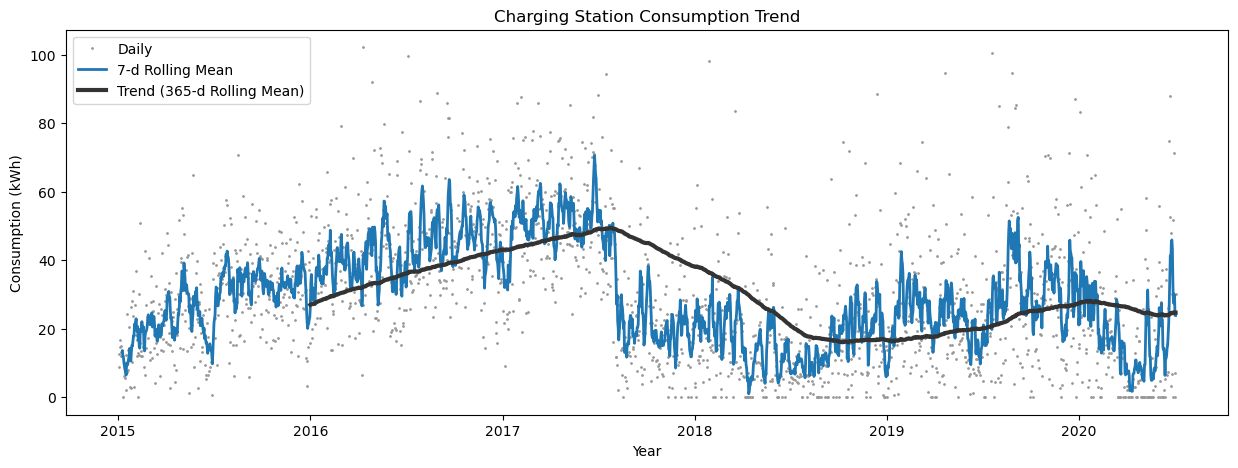

In [ ]:
plot_trends(hourly_consumption_by_station["PALO ALTO CA / CAMBRIDGE #1"])
plot_trends(hourly_consumption_by_station["PALO ALTO CA / HIGH #1"])
plot_trends(hourly_consumption_by_station["PALO ALTO CA / RINCONADA LIB 1"])

In all graphs there seem to be 2 sudden drops of consumption: in the middle of year 2017 and at the beginning of 2020.

## Autocorrelation and partial autocorrelation

Before building any model, we need to see how many datapoints from the past should we use in our autoregressive model. We can use plot_acf and plot_pacf methods to help us decide.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_autocorrelations(consumption: pd.Series):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(consumption, ax=axs[0])
    plot_pacf(consumption, ax=axs[1])
    plt.show()

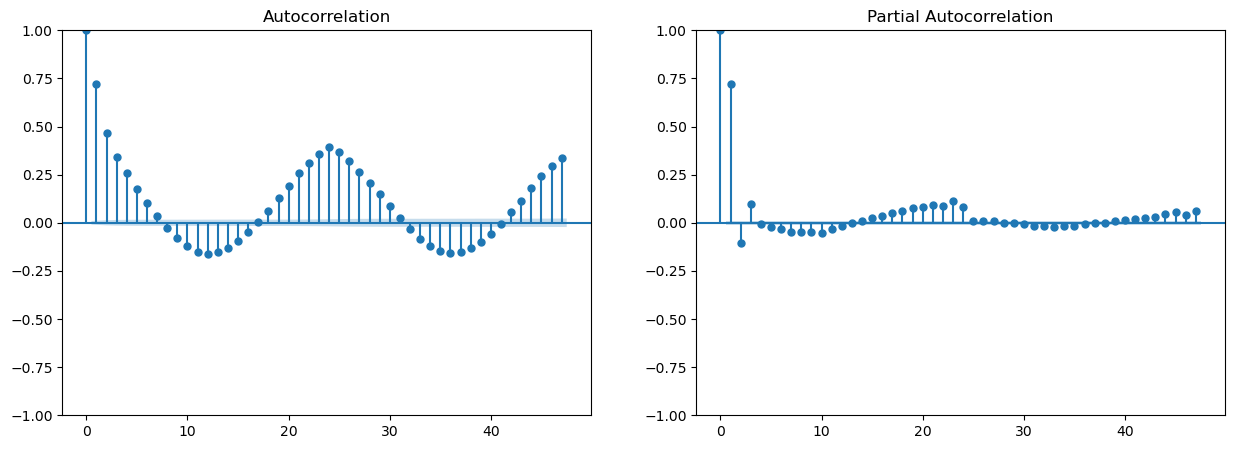

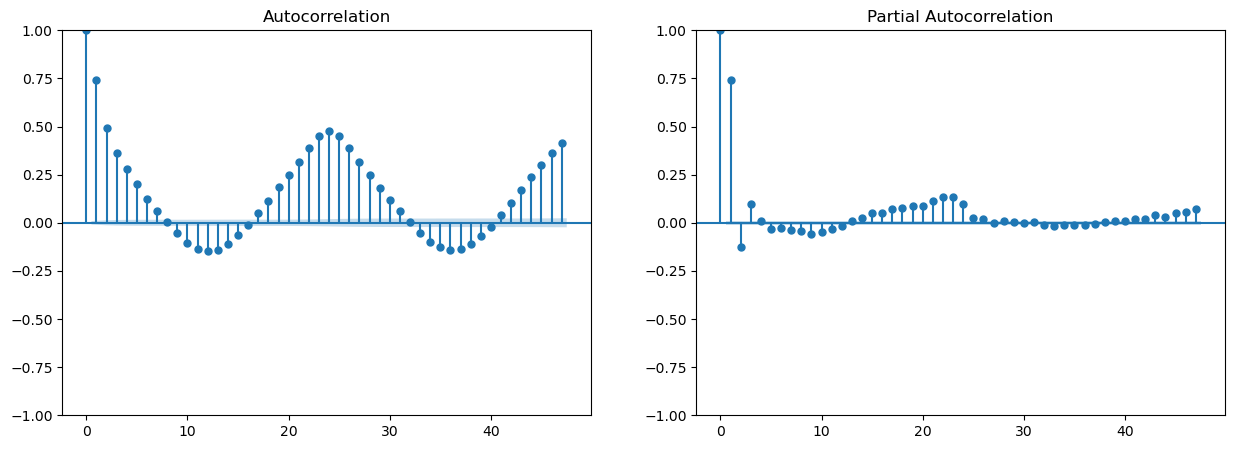

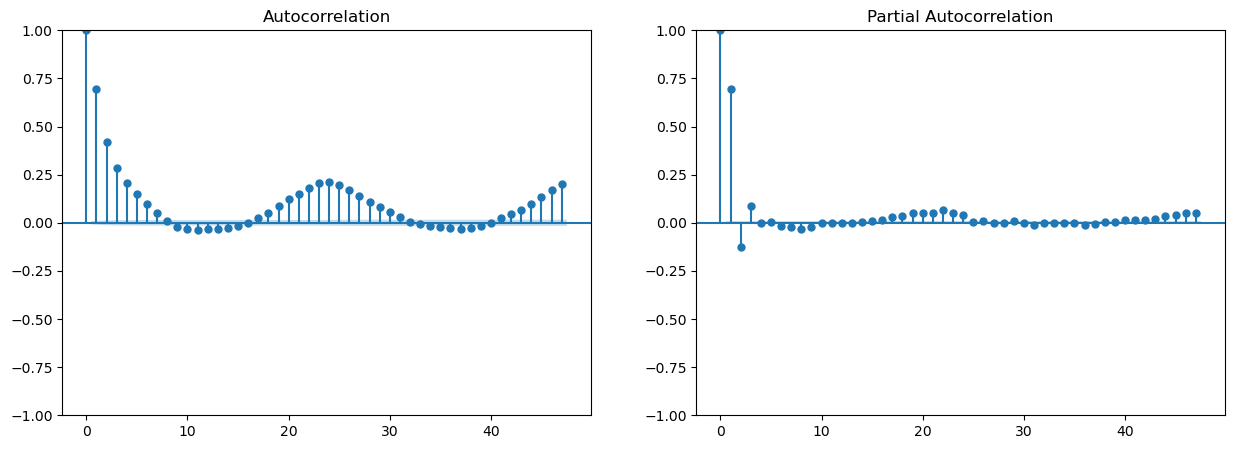

In [ ]:
plot_autocorrelations(hourly_consumption_by_station["PALO ALTO CA / CAMBRIDGE #1"])
plot_autocorrelations(hourly_consumption_by_station["PALO ALTO CA / HIGH #1"])
plot_autocorrelations(hourly_consumption_by_station["PALO ALTO CA / RINCONADA LIB 1"])

The graphs suggest that using past 3 hours along with the same hour of the previous day (indicated by the peak at 24 hour delay in the graphs) might yield the best model.

## Stationarity

The last step before building a model is determining stationarity. Looking at the graphs in the trend section, the data does not seem to stationary, but we can confirm that with a ADF test.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def print_adf_results(consumption: pd.Series):
    result = adfuller(consumption)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

We will perform the test on both hourly and daily data

In [ ]:
print_adf_results(hourly_consumption_by_station["PALO ALTO CA / CAMBRIDGE #1"])
print_adf_results(hourly_consumption_by_station["PALO ALTO CA / HIGH #1"])
print_adf_results(hourly_consumption_by_station["PALO ALTO CA / RINCONADA LIB 1"])

ADF Statistic: -16.285036
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistic: -13.199290
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -18.693395
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [ ]:
print_adf_results(hourly_consumption_by_station["PALO ALTO CA / CAMBRIDGE #1"].resample("D").sum())
print_adf_results(hourly_consumption_by_station["PALO ALTO CA / HIGH #1"].resample("D").sum())
print_adf_results(hourly_consumption_by_station["PALO ALTO CA / RINCONADA LIB 1"].resample("D").sum())

ADF Statistic: -2.777998
p-value: 0.061486
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Statistic: -2.014248
p-value: 0.280361
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Statistic: -2.982304
p-value: 0.036580
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Interestingly, the hourly data seems to be stationary while daily data does not. The reason might be that there is a long term trend (over years) which hourly test can't detect. So, just to make sure, we will use first order differencing in our model.

## Creating training and test data

In [ ]:
test_size = 0.3
training_data = dict()
test_data = dict()
for station_name, hourly_df in hourly_consumption_by_station.items():
    index = int(len(hourly_df) * (1 - test_size))
    training_data[station_name] = hourly_df.iloc[:index]
    test_data[station_name] = hourly_df.iloc[index:]

## Evaluation

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

def print_stats(y_test, y_preds, title="You forgot the title!"):
    print(title+": ")
    print("\tr^2=%f"%r2_score(y_test,y_preds))
    print("\tMAE=%f"%mean_absolute_error(y_test,y_preds))

## Baseline model

We decided to use historical averages for each hour of the day in the week for our baseline model.

PALO ALTO CA / CAMBRIDGE #1: 
	r^2=0.029023
	MAE=1.796099


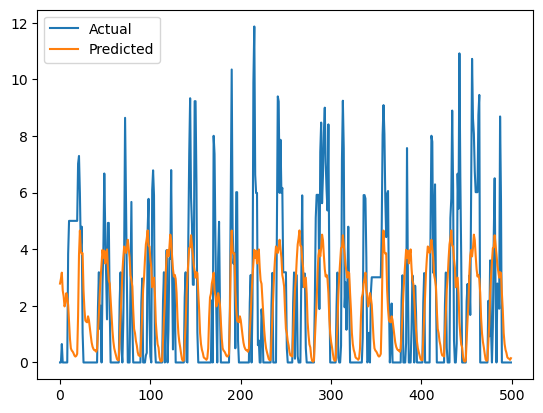

In [ ]:
# Filter for each day of the week
days_in_week = 7
daily_distributions = []
for day in range(days_in_week):
    day_of_week_data = training_data["PALO ALTO CA / CAMBRIDGE #1"][training_data["PALO ALTO CA / CAMBRIDGE #1"].index.dayofweek == day]
    daily_distributions.append(day_of_week_data.groupby(day_of_week_data.index.hour).mean())

# Create predictions
predictions = []
for i in range(len(test_data["PALO ALTO CA / CAMBRIDGE #1"])):
    day_of_week = test_data["PALO ALTO CA / CAMBRIDGE #1"].index[i].dayofweek
    hour = test_data["PALO ALTO CA / CAMBRIDGE #1"].index[i].hour
    predictions.append(daily_distributions[day_of_week][hour])

# Calculate and print stats and plot results
print_stats(test_data["PALO ALTO CA / CAMBRIDGE #1"].values, predictions, "PALO ALTO CA / CAMBRIDGE #1")
plt.plot(test_data["PALO ALTO CA / CAMBRIDGE #1"].values[0:500], label="Actual")
plt.plot(predictions[0:500], label="Predicted")
plt.legend(["Actual", "Predicted"])
plt.show()

## SARIMAX model

In [ ]:
pd.DataFrame(training_data["PALO ALTO CA / CAMBRIDGE #1"], columns=["Consumption"])

,0
2016-01-14 11:00:00,3.971721
2016-01-14 12:00:00,0.708775
2016-01-14 13:00:00,0.000000
2016-01-14 14:00:00,0.000000
2016-01-14 15:00:00,0.000000
...,...
2019-07-06 06:00:00,0.000000
2019-07-06 07:00:00,0.000000
2019-07-06 08:00:00,0.000000
2019-07-06 09:00:00,0.000000


In [1]:
from xgboost import XGBRegressor

# Function to create lag features
def create_lag_features(df):
    lags = [1, 2, 3]#, 24, 48, 72, 168, 336, 504]
    for lag in lags:
        df[f"lag_{lag}"] = df["Consumption"].shift(lag)
    return df

lagged_df_training = create_lag_features(pd.DataFrame(training_data["PALO ALTO CA / CAMBRIDGE #1"], columns=["Consumption"]))
lagged_df_test = create_lag_features(pd.DataFrame(test_data["PALO ALTO CA / CAMBRIDGE #1"], columns=["Consumption"]))
lagged_df_training = lagged_df_training.dropna().reset_index(drop=True)
lagged_df_test = lagged_df_test.dropna().reset_index(drop=True)


# Splitting into features and target
X_train = lagged_df_training.drop(columns=["Consumption"])
y_train = lagged_df_training["Consumption"]

X_test = lagged_df_training.drop(columns=["Consumption"])
y_test = lagged_df_test["Consumption"]

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_preds = model.predict(X_test)
print_stats(y_test, y_preds, "XGBoost")

NameError: name 'pd' is not defined

In [314]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the seasonal period for daily seasonality in hourly data
seasonal_period = 24  # 24 hours per day

# Training the SARIMA model on the training data
model = SARIMAX(training_data["PALO ALTO CA / CAMBRIDGE #1"].iloc[:1000], order=(3, 1, 2), seasonal_order=(3, 1, 3, seasonal_period))
SARIMA_model = model.fit()
print(SARIMA_model.summary())

# Forecasting with the SARIMA model, appending each new observation without refitting
preds = []
for l in range(0, len(test_data["PALO ALTO CA / CAMBRIDGE #1"])):
    preds.append(SARIMA_model.forecast()[0])  # Get a one-step forecast
    next_observation = test_data["PALO ALTO CA / CAMBRIDGE #1"].iloc[l]
    
    # Append the next observation without refitting the model
    SARIMA_model = SARIMA_model.append(next_observation, refit=False)

plt.plot(test_data["PALO ALTO CA / CAMBRIDGE #1"].values[0:500], label="Actual")
plt.plot(predictions[0:500], label="Predicted")
plt.legend(["Actual", "Predicted"])
plt.show()
print_stats(test_data["PALO ALTO CA / CAMBRIDGE #1"].values, predictions, "PALO ALTO CA / CAMBRIDGE #1")


c:\Users\vbran\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                 1000
Model:             SARIMAX(3, 1, 2)x(3, 1, [1, 2, 3], 24)   Log Likelihood               -1805.167
Date:                                    Wed, 20 Nov 2024   AIC                           3634.334
Time:                                            00:17:53   BIC                           3692.924
Sample:                                        01-14-2016   HQIC                          3656.630
                                             - 02-25-2016                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3476      0.041     -8.507      0

C:\Users\vbran\AppData\Local\Temp\ipykernel_10748\2457000155.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preds.append(SARIMA_model.forecast()[0])  # Get a one-step forecast


TypeError: object of type 'numpy.float64' has no len()